The csv file used here is the ndbc + era 5 data from station 44093, I save it to a csv file but later on we will switch to the time series data from Copernicus Data Store just because using API take too much time.

In [ ]:
pip install numpy pandas scikit-learn matplotlib tensorflow

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load data
df = pd.read_csv("final_ndbc_data.csv")

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Sequence creation
def create_sequences(data, target_col, n_past, n_future):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, :])
        y.append(data[i + n_future - 1, target_col])
    return np.array(X), np.array(y)

n_past = 24   # past 24 hours
n_future = 6  # forecast 6 hours ahead
X, y = create_sequences(scaled_data, target_col=0, n_past=n_past, n_future=n_future)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Loss Over Epochs")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'final_ndbc_data.csv'

In [ ]:
# Predict
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 0.0372, RMSE: 0.0593, R²: 0.7528


In [ ]:
# Create placeholder to use inverse transform
predicted_full = np.zeros((len(y_pred), scaled_data.shape[1]))
actual_full = np.zeros((len(y_test), scaled_data.shape[1]))

# Put predictions in the right column (WVHT is index 0)
predicted_full[:, 0] = y_pred[:, 0]
actual_full[:, 0] = y_test

# Inverse transform
predicted_real = scaler.inverse_transform(predicted_full)[:, 0]
actual_real = scaler.inverse_transform(actual_full)[:, 0]

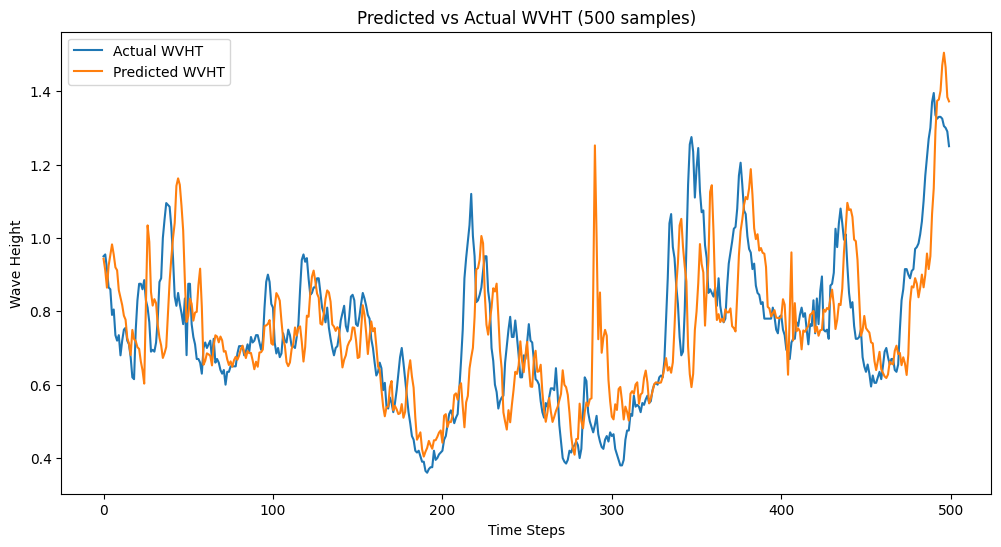

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual_real[:500], label='Actual WVHT')
plt.plot(predicted_real[:500], label='Predicted WVHT')
plt.title("Predicted vs Actual WVHT (500 samples)")
plt.xlabel("Time Steps")
plt.ylabel("Wave Height")
plt.legend()
plt.show()